# MVP - Qualidade de Software, Segurança e Sistemas Inteligentes
Bruna Fonseca

Dataset escolhido: Classificação de cogumelos

Esse dataset possui dados de diversos cogumelos e os classifica entre comestíveis e venenosos.

O objetivo é treinar um modelo para identificar de um cogumelo é comestível ou venenoso.


### Preparando o ambiente

Nessa etapa iremos realizar todos os imports necessários para a execução do notebook

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE


### Carregando os dados

In [2]:
# URL de importação do dataset
url = "https://raw.githubusercontent.com/brufonseca/ml_classification/main/mushrooms2.csv"

# Importa os dados para um DataFrame
dataset = pd.read_csv(url, delimiter=',')

# Exibe as primeiras linhas do dataset
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
# Exibe um resumo do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8111 non-null   object
 1   cap-shape                 8111 non-null   object
 2   cap-surface               8111 non-null   object
 3   cap-color                 8111 non-null   object
 4   bruises                   8111 non-null   object
 5   odor                      8111 non-null   object
 6   gill-attachment           8111 non-null   object
 7   gill-spacing              8111 non-null   object
 8   gill-size                 8111 non-null   object
 9   gill-color                8111 non-null   object
 10  stalk-shape               8111 non-null   object
 11  stalk-root                8111 non-null   object
 12  stalk-surface-above-ring  8111 non-null   object
 13  stalk-surface-below-ring  8111 non-null   object
 14  stalk-color-above-ring  

In [4]:
# Exibe as estatísticas do dataset
dataset.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8111,8111,8111,8111,8111,8111,8111,8111,8111,8111,...,8111,8111,8111,8111,8111,8111,8111,8111,8111,8111
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4201,3653,3239,2275,4735,3521,7908,6800,5604,1723,...,4927,4462,4379,8111,7917,7477,3961,2381,4032,3144


#### Formato do dataset
Vamos avaliar o formato do nosso dataset

In [5]:
print("Formato Dataset", dataset.shape)

Formato Dataset (8111, 23)


### Analisando os dados

#### Verificando se dados estão faltando

Vamos verficar se alguma das colunas possui dados faltando. Em caso positivo, realizaremos o tratamento necessário

In [6]:
#Exibe quantidade de valores nulos em cada coluna
dataset.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

#### Analisando a coluna alvo

*A coluna 'class' possui a informação se o cogumelo é comestível ou venenoso*


In [7]:
#Exibe a frequência de cada valor distinto da coluna
dataset['class'].value_counts()

class
e    4201
p    3910
Name: count, dtype: int64

In [8]:
# Exible os valores únicos da coluna
print(dataset["class"].unique())

['p' 'e']


Verificando se o dataset está balanceado

Distribuição dos tipos de cogumelo: Counter({'e': 4201, 'p': 3910})


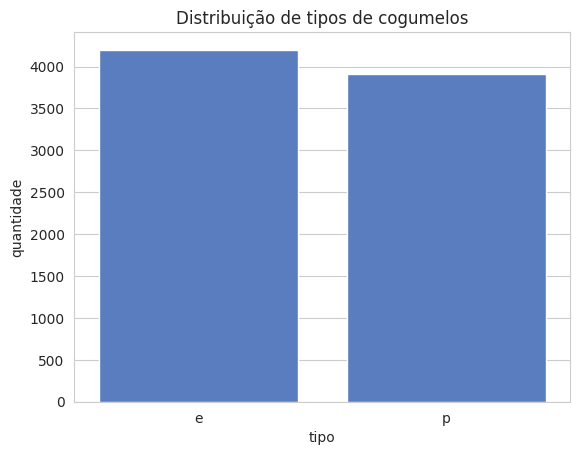

In [9]:

print("Distribuição dos tipos de cogumelo:", Counter(dataset['class']))

class_count = dataset['class'].value_counts().reset_index()
class_count.columns = ['tipo','quantidade']

sns.set_style("whitegrid")
sns.set_palette("muted")

sns.barplot(x='tipo', y='quantidade', data=class_count)

plt.title('Distribuição de tipos de cogumelos')
plt.show()



*O dataset está balanceado*

### Preparando os dados




In [10]:
# Convertendo colunas do tipo object para category
label_encoder=LabelEncoder()

for column in dataset.columns:
  if dataset[column].dtype == 'object':
    dataset[column] = label_encoder.fit_transform(dataset[column])

dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


*Colunas com todos os valores iguais serão eliminadas, pois não contribuem para a classificação*

In [11]:
# Verificar quais colunas possuem todos os valores iguais
cols = dataset.nunique() == 1
cols_list = dataset.columns[cols].tolist()

for col_name in cols_list:
    print(col_name, " possui todos os valores iguais e será eliminada")
    dataset=dataset.drop([col_name],axis=1)

dataset.head()

veil-type  possui todos os valores iguais e será eliminada


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


### Separando os dados

In [12]:
test_size = 0.25 # tamanho do conjunto de teste
seed = 11 # semente aleatória

# Separação em conjuntos de treino e teste
X = dataset.drop(['class'], axis=1)
y = dataset["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) # validação cruzada com estratificação



### Seleção de características

O dataset escolhido possui muitas colunas (22), vamos tentar descobrir quais são as mais importantes, para melhorar o desempenho do modelo.

Três abordagens serão utilizadas:

- Teste Chi-Square
- Avaliação da importância das features
- Seleção Recursiva



In [13]:
#Utilizando Chi-Square para selecionar as colunas que possuem maior correlação com a coluna alvo

# Selecionar as melhores colunas
chi2_selector = SelectKBest(chi2, k=5)  # Selecionar as 5 melhores colunas
X_train_chi2 = chi2_selector.fit_transform(X_train, y_train)

# Exibir colunas selecionadas
selected_columns_chi2 = X.columns[chi2_selector.get_support()]
print("Melhores colunas pelo Chi-Square:", selected_columns_chi2)

Melhores colunas pelo Chi-Square: Index(['bruises', 'gill-size', 'gill-color', 'stalk-root', 'ring-type'], dtype='object')


In [14]:
#Observar o atributo feature_importances_ do RF para verificar a importância das colunas

# Treinar Random Forest
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

# Exibir importância das features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Ordenar pela importância

# Exibir as colunas mais importantes
for i in range(5): 
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]}")

odor: 0.1915215877341465
gill-color: 0.12224884261568623
gill-size: 0.10043405384211299
spore-print-color: 0.09593780737108865
stalk-surface-above-ring: 0.06026379721290766


In [15]:
# Usar RFE com Decision Tree
dt = DecisionTreeClassifier(random_state=seed)
rfe_selector = RFE(estimator=dt, n_features_to_select=5, step=1)  # Selecionar 5 melhores colunas
rfe_selector = rfe_selector.fit(X_train, y_train)

# Verificar as colunas selecionadas
selected_columns_rfe = X.columns[rfe_selector.support_]
print("Melhores colunas pelo RFE:", selected_columns_rfe)

Melhores colunas pelo RFE: Index(['gill-size', 'gill-color', 'stalk-root', 'spore-print-color',
       'population'],
      dtype='object')


A partir dos resultados acima, vamos treinar o modelo utilizando as seguintes colunas do dataset:

- gill-size
- gill-color
- stalk-root
- ring-type
- spore-print-color
- bruises
- odor
- population
- stalk-surface-above-ring


Agora iremos refazer a seleção dos conjuntos de treino e teste

In [16]:

#colunas que serão usadas para treinar os modelos
columns = ['gill-size', 'gill-color', 'stalk-root', 'ring-type', 'spore-print-color','odor','population',
           'bruises','stalk-surface-above-ring']


test_size = 0.25 # tamanho do conjunto de teste
seed = 11 # semente aleatória

# Separação em conjuntos de treino e teste
X_selected = dataset[columns]
y = dataset["class"]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação




#### Modelos de Classificação

Foram escolhidos os seguintes modelos: *Regressão Logística*, *KNN*, *Árvore de Decisão*, *Naive Bayes*, *SVM* e *Random Forest*  

LR - Acurácia: 0.92 (+/- 0.01)
KNN - Acurácia: 1.00 (+/- 0.00)
CART - Acurácia: 1.00 (+/- 0.00)
NB - Acurácia: 0.87 (+/- 0.02)
SVM - Acurácia: 0.95 (+/- 0.01)
RF - Acurácia: 1.00 (+/- 0.00)


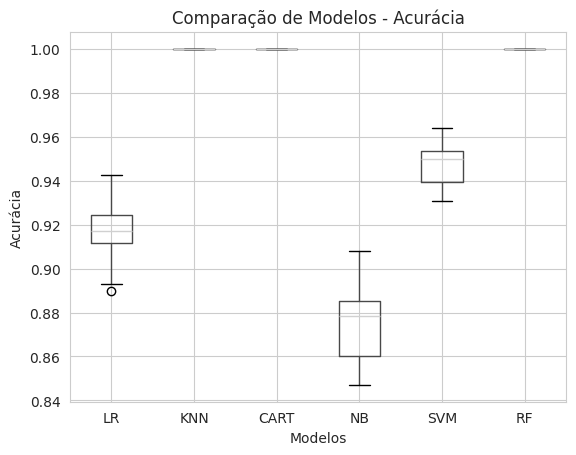

In [17]:
np.random.seed(11) # Definição de uma semente global

n_estimators = 100
max_features = 3

# Definição dos modelos de classificação
models = {
    'LR': LogisticRegression(max_iter=200, random_state=seed),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(random_state=seed),
    'NB': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=seed),
    'RF': RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
}


results = []


# Avaliação dos modelos como conjunto de treinamento
for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    mean_cv_score = np.mean(cv_results)
    results.append((name, cv_results))
    print(f'{name} - Acurácia: {cv_results.mean():.2f} (+/- {cv_results.std():.2f})')

# Boxplot de comparação dos modelos
results_df = pd.DataFrame({name: scores for name, scores in results})
results_df.boxplot()
plt.title('Comparação de Modelos - Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Modelos')
plt.show()

#### Padronização e normalização dos dados

In [18]:
np.random.seed(11) # Definição de uma semente global

n_estimators = 100
max_features = 3

# Definição dos modelos de classificação
models = {
    'LR': LogisticRegression(max_iter=200, random_state=seed),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(random_state=seed),
    'NB': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=seed),
    'RF': RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
}


# Definição dos pipelines de normalização e padronização
pipelines = {
    'Standard Scaling': StandardScaler(),
    'MinMax Scaling': MinMaxScaler()
}

# Treinamento e avaliação dos modelos com pipelines de normalização e padronização
for scale_name, scaler in pipelines.items():
    print(f"\nPipeline de {scale_name}:\n")
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', model)
        ])

        scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
        results.append((model_name + "-" + scale_name, scores))

        print(f"{model_name} - Acurácia: {scores.mean():.2f}, Desvio Padrão: {scores.std():.2f}")





Pipeline de Standard Scaling:

LR - Acurácia: 0.92, Desvio Padrão: 0.02
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.87, Desvio Padrão: 0.02
SVM - Acurácia: 0.95, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00

Pipeline de MinMax Scaling:

LR - Acurácia: 0.91, Desvio Padrão: 0.01
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.87, Desvio Padrão: 0.02
SVM - Acurácia: 0.94, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00


In [19]:
""" Pipeline de Standard Scaling:

LR - Acurácia: 0.92, Desvio Padrão: 0.02
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.87, Desvio Padrão: 0.02
SVM - Acurácia: 0.95, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00

Pipeline de MinMax Scaling:

LR - Acurácia: 0.91, Desvio Padrão: 0.01
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.87, Desvio Padrão: 0.02
SVM - Acurácia: 0.94, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00 """

' Pipeline de Standard Scaling:\n\nLR - Acurácia: 0.92, Desvio Padrão: 0.02\nKNN - Acurácia: 1.00, Desvio Padrão: 0.00\nCART - Acurácia: 1.00, Desvio Padrão: 0.00\nNB - Acurácia: 0.87, Desvio Padrão: 0.02\nSVM - Acurácia: 0.95, Desvio Padrão: 0.01\nRF - Acurácia: 1.00, Desvio Padrão: 0.00\n\nPipeline de MinMax Scaling:\n\nLR - Acurácia: 0.91, Desvio Padrão: 0.01\nKNN - Acurácia: 1.00, Desvio Padrão: 0.00\nCART - Acurácia: 1.00, Desvio Padrão: 0.00\nNB - Acurácia: 0.87, Desvio Padrão: 0.02\nSVM - Acurácia: 0.94, Desvio Padrão: 0.01\nRF - Acurácia: 1.00, Desvio Padrão: 0.00 '

#### Otimização dos hiperparâmetros

In [20]:
np.random.seed(11) # Definição de uma semente global

# Definição dos modelos e dos espaços de hiperparâmetros para Grid Search
param_grids = {
    'Naive Bayes': {
        'classifier': GaussianNB(),
        'params':{
            'var_smoothing': [1e-9, 1e-8, 1e-7]   
        }
    },
    'KNN': {
        'classifier': KNeighborsClassifier(),
        'params':{
            'n_neighbors': [1, 3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ["euclidean", "manhattan", "minkowski"]
        }
        
    },
    'Logistic Regression': {
        'classifier':LogisticRegression(max_iter=100),
        'params':{
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
        }
        
    },
    'Decision Tree': {
        'classifier': DecisionTreeClassifier(),
        'params':{
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10]
        }
        
    },
    'Random Forest': {
        'classifier': RandomForestClassifier(),
        'params':{
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_leaf': [1, 2, 4]
        }
        
    },
    'SVM': {
        'classifier': SVC(),
        'params':{
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
        

    }
}

# Dicionário para armazenar os melhores modelos e suas performances
selected_models = {}

# Realização do Grid Search para cada modelo
for model_name, param_grid in param_grids.items():
    print(f"\nOtimização de hiperparâmetros para {model_name}...\n")

    grid_search = GridSearchCV(param_grid['classifier'], param_grid['params'], cv=kfold, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    selected_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
    print(f"Melhor acurácia para {model_name}: {grid_search.best_score_:.2f}")





Otimização de hiperparâmetros para Naive Bayes...

Melhores parâmetros para Naive Bayes: {'var_smoothing': 1e-09}
Melhor acurácia para Naive Bayes: 0.87

Otimização de hiperparâmetros para KNN...

Melhores parâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Melhor acurácia para KNN: 1.00

Otimização de hiperparâmetros para Logistic Regression...

Melhores parâmetros para Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Melhor acurácia para Logistic Regression: 0.92

Otimização de hiperparâmetros para Decision Tree...

Melhores parâmetros para Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Melhor acurácia para Decision Tree: 1.00

Otimização de hiperparâmetros para Random Forest...

Melhores parâmetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Melhor acurácia para Random Forest: 1.00

Otimização de hiperparâmetros p

In [21]:
""" Otimização de hiperparâmetros para Naive Bayes...

Melhores parâmetros para Naive Bayes: {'var_smoothing': 1e-09}
Melhor acurácia para Naive Bayes: 0.87

Otimização de hiperparâmetros para KNN...

Melhores parâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Melhor acurácia para KNN: 1.00

Otimização de hiperparâmetros para Logistic Regression...

Melhores parâmetros para Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Melhor acurácia para Logistic Regression: 0.92

Otimização de hiperparâmetros para Decision Tree...

Melhores parâmetros para Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Melhor acurácia para Decision Tree: 1.00

Otimização de hiperparâmetros para Random Forest...

Melhores parâmetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Melhor acurácia para Random Forest: 1.00
...
Otimização de hiperparâmetros para SVM...

Melhores parâmetros para SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Melhor acurácia para SVM: 1.00 """

" Otimização de hiperparâmetros para Naive Bayes...\n\nMelhores parâmetros para Naive Bayes: {'var_smoothing': 1e-09}\nMelhor acurácia para Naive Bayes: 0.87\n\nOtimização de hiperparâmetros para KNN...\n\nMelhores parâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}\nMelhor acurácia para KNN: 1.00\n\nOtimização de hiperparâmetros para Logistic Regression...\n\nMelhores parâmetros para Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}\nMelhor acurácia para Logistic Regression: 0.92\n\nOtimização de hiperparâmetros para Decision Tree...\n\nMelhores parâmetros para Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}\nMelhor acurácia para Decision Tree: 1.00\n\nOtimização de hiperparâmetros para Random Forest...\n\nMelhores parâmetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}\nMelhor acurácia para Random Forest: 1.00\n...\nOt

#### Finalização do Modelo

Avaliando os resultados obtidos nas etapas anteriores, observamos que bons resultados foram obtidos mesmo sem o uso de padronização/normalização dos dados. 

Os melhores resultados foram observados para os modelos: *KNN*, *Decision Tree*,*Random Forest* e *SVM*

In [22]:
# Otimização de hiperparâmetros para KNN...

## Melhores parâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
## Melhor acurácia para KNN: 1.00

## Melhores parâmetros para Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
## Melhor acurácia para Decision Tree: 1.00

## Melhores parâmetros para Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
## Melhor acurácia para Random Forest: 1.00

## Melhores parâmetros para SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
## Melhor acurácia para SVM: 1.00

In [23]:
## Melhores parâmetros para Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
## Melhor acurácia para Decision Tree: 1.00

# Avaliando com o Decision Tree

np.random.seed(11)

# Preparação do modelo
model = DecisionTreeClassifier(criterion='gini',max_depth=None, min_samples_split=2)
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

1.0


##### Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [24]:
""" np.random.seed(11)

model = DecisionTreeClassifier(criterion='gini',max_depth=None, min_samples_split=2)

pipeline = Pipeline(steps=[('KNN', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions)) """

" np.random.seed(11)\n\nmodel = DecisionTreeClassifier(criterion='gini',max_depth=None, min_samples_split=2)\n\npipeline = Pipeline(steps=[('KNN', model)])\n\npipeline.fit(X_train, y_train)\npredictions = pipeline.predict(X_test)\nprint(accuracy_score(y_test, predictions)) "

##### Salvando os arquivos

In [25]:
# Salvando o modelo
model_filename = 'dt_mushroom_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o pipeline
""" pipeline_filename = 'dt_mushroom_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file) """

# Salvando X_test e y_test

columns = ['gill-size', 'gill-color', 'stalk-root', 'ring-type', 'spore-print-color','odor','population',
           'bruises','stalk-surface-above-ring']

X_selected = dataset[columns]
y = dataset["class"]

X_test_df = pd.DataFrame(X_test, columns=columns)
y_test_df = pd.DataFrame(y_test, columns=['class'])
X_test_df.to_csv("../data/X_test_dataset_mushroom.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_mushroom.csv", index=False)


##### Simulando a aplicação do modelo em dados não vistos

In [26]:

model.fit(X_selected, y)

DecisionTreeClassifier()

In [27]:
data = {
       'gill-size':[0,1],
       'gill-color':[6,0],
       'stalk-root':[0,0],
       'ring-type':[4,0],
       'spore-print-color':[4,7],
       'odor':[5,7],
       'population':[1,4],
       'bruises':[0,0],
       'stalk-surface-above-ring':[2,2],
}


atributos = ['gill-size', 'gill-color', 'stalk-root', 'ring-type', 'spore-print-color','odor','population',
           'bruises','stalk-surface-above-ring']


entrada = pd.DataFrame(data, columns=atributos)

X_entrada = entrada[:]


In [28]:
# Predição de classes dos dados de entrada
saidas = model.predict(X_entrada)
print(saidas)

[0 1]
